In [1]:
import misleading_image.community_note_generation as cng 

In [2]:
test_set = cng.get_test_set("12-21-2024/tweets_with_community_notes.json")

Checking image urls...
Found 49 good tweets out of 50


c:\Users\ethan\PycharmProjects\XCommunityNotesDatasetBuilder\misleading_image\community_note_generation\__init__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generation_df["original_cn"] = df["community_note"].apply(lambda x: x["summary"])


In [3]:
import re

def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Replace newlines, tabs, and commas with spaces
    text = text.replace('\n', ' ').replace('\t', ' ').replace(',', ' ')
    return text

# Example usage
cleaned_text = clean_text("Some text with non-ASCII characters: ñ, é, ü, and newlines\nand tabs\t.")
print(cleaned_text)

Some text with non-ASCII characters:          and newlines and tabs .


In [4]:
print(test_set.head())

                                                  text  \
278  Entrano a Villa Arcore baldracche, uscivano ch...   
198  Our national nightmare is over https://t.co/nA...   
241  @elonmusk Let's that sink in https://t.co/uk1b...   
199  🚨BREAKING: 5,000+ tractors expected to shut do...   
376  🚨🚨 Breaking:\n\nAn Israeli helicopter has just...   

                                            image_urls  \
278  [https://pbs.twimg.com/media/GexGqfiXkAE1wge.png]   
198  [https://pbs.twimg.com/media/GeHzvPNWsAIQ62N.jpg]   
241  [https://pbs.twimg.com/media/GchHZqMaMAEDBEb.jpg]   
199  [https://pbs.twimg.com/media/GcqZzo7W8AA3j-e.jpg]   
376  [https://pbs.twimg.com/media/GdB-1pYXwAAiF1U.jpg]   

                                             tweet_url  \
278  https://twitter.com/RobertoAvventu2/status/186...   
198  https://twitter.com/still_boneless/status/1865...   
241  https://twitter.com/TRUMP_ARMY_/status/1857813...   
199  https://twitter.com/Inevitablewest/status/1858...   
376  https:/

In [5]:
from misleading_image.twc import TweetWithContext as TWC
from misleading_image.gemini import Gemini
from misleading_image.community_note_generation.gemini_multishot_cng import generate_community_note as gcn
import pandas as pd
# Without grounding 
# Iterate through each row
gemini = Gemini("misleading_image/google.key")
outs = []
for index, row in test_set.iterrows():
    tweet = TWC(row["text"], row['image_urls'][0], row['original_cn'])
    response = gcn(tweet.text, tweet.image, gemini, google_ground=False)
    # Assert no grounding
    grounding = response.candidates[0].grounding_metadata
    assert grounding is None

    outs.append(clean_text(response.text))

test_set['generated_cn_no_grounding'] = outs

# Save df
test_set.to_csv("test_set.csv")


In [8]:
# Load csv
import pandas as pd

# add a new generated column with grounding
outs = []
for index, row in test_set.iterrows():
    print(row)
    print(row['image_urls'][0])
    tweet = TWC(row["text"], row['image_urls'][0], row['original_cn'])
    response = gcn(tweet.text, tweet.image, gemini, google_ground=True)
    outs.append(response.text)
    assert(response.candidates[0].grounding_metadata is not None)
test_set['generated_cn_with_grounding'] = outs

# Save df
test_set.to_csv("test_set.csv")

text                         Entrano a Villa Arcore baldracche, uscivano ch...
image_urls                   [https://pbs.twimg.com/media/GexGqfiXkAE1wge.png]
tweet_url                    https://twitter.com/RobertoAvventu2/status/186...
original_cn                  The woman pictured in lingerie is not the same...
generated_cn_no_grounding    The tweet is making a derogatory and sexist co...
Name: 278, dtype: object
https://pbs.twimg.com/media/GexGqfiXkAE1wge.png
text                         Our national nightmare is over https://t.co/nA...
image_urls                   [https://pbs.twimg.com/media/GeHzvPNWsAIQ62N.jpg]
tweet_url                    https://twitter.com/still_boneless/status/1865...
original_cn                  Haliey Welch's X account has not been suspende...
generated_cn_no_grounding    The attached image shows the account @haileywe...
Name: 198, dtype: object
https://pbs.twimg.com/media/GeHzvPNWsAIQ62N.jpg
text                         @elonmusk Let's that sink in https:

In [21]:
# Score each of the generated community notes rows
from misleading_image.community_note_generation.generation_scorer import score
import time 

grounding_scores = []
no_grounding_scores = []
for index, row in test_set.iterrows():
    print(row)
    while True:
        try:
            grounding_score = score(row['generated_cn_with_grounding'], row['original_cn'])
            no_grounding_score = score(row['generated_cn_no_grounding'], row['original_cn'])
            break
        except Exception as e:
            print(e)
            time.sleep(10)
            continue
    grounding_scores.append(grounding_score)
    no_grounding_scores.append(no_grounding_score)

test_set['grounding_scores'] = grounding_scores
test_set['no_grounding_scores'] = no_grounding_scores

# Save df
test_set.to_csv("test_set.csv")



text                           Entrano a Villa Arcore baldracche, uscivano ch...
image_urls                     [https://pbs.twimg.com/media/GexGqfiXkAE1wge.png]
tweet_url                      https://twitter.com/RobertoAvventu2/status/186...
original_cn                    The woman pictured in lingerie is not the same...
generated_cn_no_grounding      The tweet is making a derogatory and sexist co...
generated_cn_with_grounding    The image accompanying this tweet is misleadin...
grounding_scores               {'score': 0.1, 'reason': 'The generated note i...
no_grounding_scores            {'score': 0.1, 'reason': 'The generated commun...
Name: 278, dtype: object
text                           Our national nightmare is over https://t.co/nA...
image_urls                     [https://pbs.twimg.com/media/GeHzvPNWsAIQ62N.jpg]
tweet_url                      https://twitter.com/still_boneless/status/1865...
original_cn                    Haliey Welch's X account has not been suspende...
gen

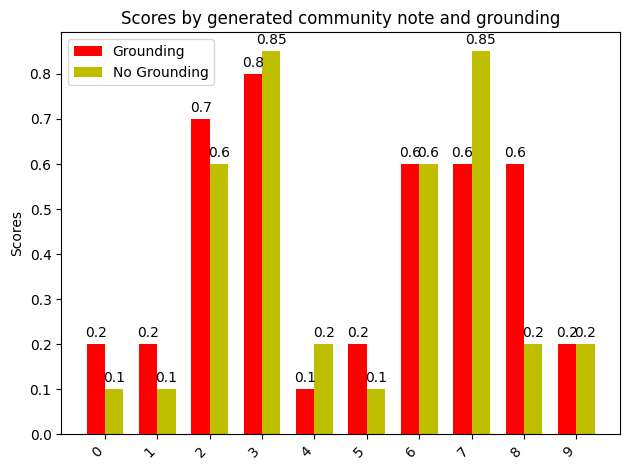

In [22]:
# Generate a double bar plot of the scores
# pip install matplotlib

# %pip install matplotlib

import matplotlib.pyplot as plt
import numpy as np

# Data
N = len(test_set)
grounding_means = [float(x['score']) for x in test_set['grounding_scores']]
no_grounding_means = [float(x['score']) for x in test_set['no_grounding_scores']]

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(ind, grounding_means, width, label='Grounding', color='r')
rects2 = ax.bar(ind + width, no_grounding_means, width, label='No Grounding', color='y')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by generated community note and grounding')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(list(range(len(test_set))), rotation=45, ha='right')

ax.legend()

# Function to add labels on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()
plt.show()